# Set up

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import cifar_utils
import clipper_manager as cl
import pandas as pd
import numpy as np
from sklearn import linear_model as lm
from sklearn import svm
import tensorflow as tf
from skimage import io
import matplotlib as mpl
mpl.rc("savefig", dpi=200)
import matplotlib.pyplot as plt
%matplotlib inline


### Load CIFAR-10 data and train/load models

In [ ]:
cifar_path = os.path.expanduser("~/model-serving/data/cifar")
train_x, train_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_train.data", norm=True))
test_x, test_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=True))
no_norm_x, no_norm_y = cifar_utils.filter_data(
    *cifar_utils.load_cifar(cifar_path, cifar_filename="cifar_test.data", norm=False))

# Train Scikit-Learn Logistic Regression model
def train_model(m, train_x, train_y):
    m.fit(train_x, train_y)
    return m
lin_model = train_model(lm.LogisticRegression(), train_x, train_y)

# Load pre-trained TF model
tf_cifar_model_path = os.path.expanduser(
    "~/clipper-cpp/examples/cifar_demo/tf_cifar_model/cifar10_model_full")
tf_session = tf.Session('', tf.Graph())
with tf_session.graph.as_default():
    saver = tf.train.import_meta_graph("%s.meta" % tf_cifar_model_path)
    saver.restore(tf_session, tf_cifar_model_path)

def tensorflow_score(session, test_x, test_y):
    """
    NOTE: This predict method expects pre-whitened (normalized) images
    """
    logits = session.run('softmax_logits:0',
                           feed_dict={'x:0': test_x})
    relevant_activations = logits[:, [cifar_utils.negative_class, cifar_utils.positive_class]]
    preds = np.argmax(relevant_activations, axis=1)
    preds[preds == 0] = -1.0
    return float(np.sum(preds == test_y)) / float(len(test_y))


# Demo: Is it a bird? Is it a plane? It's probably not Superman...
<img style="float: left;" src="superman.png">

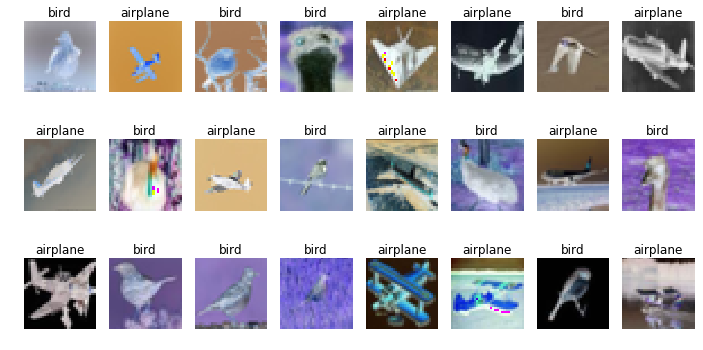

In [64]:
cifar_utils.plot_random_images(no_norm_x, no_norm_y, 3)

In [ ]:
import clipper_manager as cl
ec2_host = "ec2-54-67-123-237.us-west-1.compute.amazonaws.com"
user = "ubuntu"
key = os.path.expanduser("~/.ssh/aws_rsa")
clipper = cl.Cluster(ec2_host, user, key)

In [ ]:
clipper.start_clipper()

In [ ]:
clipper.list_apps()

In [ ]:
app_name = "rise_demo"
candidate_models = [
    {"model_name": "sklearn_cifar", "model_version": 1},
    {"model_name": "tf_cifar", "model_version": 1},
]

clipper.add_app(app_name, candidate_models,
                input_type="doubles", slo_micros=50000)

In [ ]:
clipper.get_app_info(app_name)

# Offline eval of trained models

In [ ]:
print("Logistic Regression test score: %f" % lin_model.score(test_x, test_y))

## Deploy Scikit-Learn Model to Clipper

In [ ]:
# TODO TODO TODO: Before merge, change :test to :latest

model_added = clipper.add_sklearn_model(
    "sklearn_cifar",
    1,
    lin_model,
    "clipper/sklearn_cifar_container:test",
    ["cifar", "sklearn"],
    input_type="doubles",
    num_containers=1
)

## Deploy TensorFlow Model to Clipper

In [ ]:
print("TensorFlow CNN test score: %f" % tensorflow_score(tf_session, test_x, test_y))

In [ ]:
# TODO TODO TODO: Before merge, change :test to :latest

model_added = clipper.add_model(
    "tf_cifar",
    1,
    "/Users/crankshaw/clipper-cpp/examples/cifar_demo/tf_cifar_model",
    "clipper/tf_cifar_container:test",
    ["cifar", "tf"],
    input_type="ints",
    num_containers=1
)

In [ ]:
clipper.get_selection_state(app_name, 0)

# Clean Up

In [ ]:
# clipper.stop_all()
# clipper.pull_docker_images()
clipper.cleanup()